# Calculating Mutation Load Using TCGA Breast Cancer Dataset

DNA mismatch repair (MMR) mechanism is responsible for fixing errors that occur during DNA replication in addition to proofreading. The goal of this analysis is to investigate how damages in MMR pathway could affect the number of mutations, also known as mutation load, in cancer.

For the analysis, we will be using MAF files of TCGA breast cancer data set. When the dataset is loaded, we will only keep the mutations that pass the filter. 

In [2]:
import os

cwd = os.getcwd()
DATA = cwd + '/data'

In [5]:
import pandas as pd

pd.set_option('display.max_columns', None)

maf_file = DATA + "/TCGA.BRCA.mutect.995c0111-d90b-4140-bee7-3845436c3b42.DR-10.0.somatic.maf.gz"

maf = pd.read_csv(maf_file, sep="\t", comment='#')

maf.head()

mut = maf[(maf.FILTER == "PASS") & ((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria, {:.2f}%".format(
    len(mut), len(maf), 100 * len(mut) / len(maf)))

/Users/crystalshin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (87,88,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


73156 out of 120988 mutations passed the filtering criteria, 60.47%


We will focus on 11 MMR genes that are highlighted in [Cortes-Ciriano et al. paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5467167/figure/f1/). Using the MAF file, patients with at least one mutation with moderate/high impact can be identified.

In [7]:
mmr = {"MLH1", "MLH3", "MSH2", "MSH3", "MSH6", "PMS1", "PMS2", "POLE", "POLD1", "PRKDC", "APC"}

Now, we can calculate the mutation load of each sample in the MAF file, and also identify each sample with mutations in its MMR gene. Mutation load can be calculated by aggregating the number of rows in each sample. To identify the samples that have MMR gene mutations, we can simply search for unique samples that are identified as one of the 11 MMR genes.

In [8]:
mutation_load = maf.groupby("Tumor_Sample_Barcode").CONTEXT.size()

mut_mmr_samples = maf[maf.Hugo_Symbol.isin(mmr)].Tumor_Sample_Barcode.unique()

We can now plot a boxplot to visualize how mutation loads differ for MMR and non-MMR genes. The scale of y-axis can be set to log-scale since the boxplot might be highly distorted. 

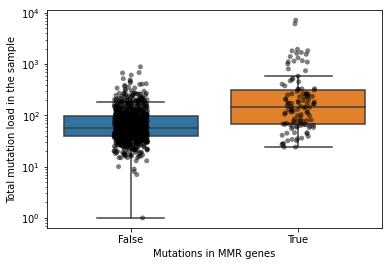

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plotdata = pd.DataFrame({"mutation_load": mutation_load, "mutation_in_MMR": False})
plotdata.loc[mut_mmr_samples, "mutation_in_MMR"] = True

ax = sns.boxplot(x="mutation_in_MMR", y="mutation_load", data=plotdata, fliersize=0)
ax = sns.stripplot(x="mutation_in_MMR", y="mutation_load", data=plotdata, alpha=0.5, color="black")

ax.set_xlabel("Mutations in MMR genes")
ax.set_ylabel("Total mutation load in the sample")
ax.set_yscale('log')

From the boxplot, it is evident that samples with mutations in MMR genes have much higher mutation loads than those for samples without mutations in MMR genes. To further confirm the statistical significance of this result, a Mann-Whitney U Test can be performed. Mann-Whitney U test is more robust and appropriate in our case, since the distribution of mutation load has a long tail and given our large sample size, applying a non-parametric test is more appropriate.

In [13]:
import numpy as np
from scipy.stats import mannwhitneyu

U1, p = mannwhitneyu(plotdata[plotdata.mutation_in_MMR].mutation_load, plotdata[~plotdata.mutation_in_MMR].mutation_load)
print(p)

3.755112755500161e-19


The p-value from the MWU test is significantly less than 0.05, suggesting that the result is statistically significant. We observe difference in mutation loads between samples with mutations in MMR and samples without, because mutation in MMR genes impair the ability of these genes to successfully perform its job of repairing the damage and transcription errors in the DNA. Therefore, the frequency of mutation would go up for samples with mutations in MMR as these mutations are not fixed by the MMR genes as effectively.